---

# Import Libraries

In this section we import the libraries that will be required to process the data.

The first library is **Pandas**.  
Pandas is an open source, BSD-licensed library, providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [1]:
# Import Pandas and Numpy to provide DataFrame support
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

In [2]:
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

font = {'size'   : 12}
mpl.rc('font', **font)

In [3]:
# Use Folium to display the Maps for Visualisation
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

# Module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 


In [4]:
import yaml

with open("./capstone_data/config.yaml", "r") as f:
    cfg = yaml.load(f)
 
search_params = {
    'client_id': cfg['client_id'],
    'client_secret': cfg['client_secret'],
    'intent': 'browse',
    'limit': 50,
    'v': cfg['version']
}

In [6]:
# All the SciKit Learn Libraries Required
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores




---

# Import and process the Chicago Crime DataSet
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago in the last year, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

| Column Name   | Type          | Description                                            | 
| :------------ | :------------ | :----------------------------------------------------- | 
| CASE#         | Plain Text    | The Chicago Police Department RD Number (Records Division Number), which is unique to the incident. | 
| DATE OF OCCURRENCE | Date & Time   | Date when the incident occurred. this is sometimes a best estimate. |
| BLOCK	        | Plain Text    | The partially redacted address where the incident occurred, placing it on the same block as the actual address. |
| IUCR	        | Plain Text    | The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e. |
| PRIMARY DESCRIPTION   | Plain Text    | The primary description of the IUCR code. |
| SECONDARY DESCRIPTION	| Plain Text    | The secondary description of the IUCR code, a subcategory of the primary description. |
| LOCATION DESCRIPTION | Plain Text | Description of the location where the incident occurred. |
| ARREST        | Plain Text    | Indicates whether an arrest was made. |
| DOMESTIC      | Plain Text    | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act. |
| BEAT          | Plain Text    | Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74. |
| WARD	        | Number        | The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76. |
| FBI CD        | Plain Text    | Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html. |
| X COORDINATE	| Plain Text    | The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| Y COORDINATE	| Plain Text    | The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LATITUDE	    | Number        | The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LONGITUDE	    | Number        | The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LOCATION	    | Location      | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block. |
	




### Import the 2018 DataSet

The full dataset, 2001 to 2018 contains over 6.7M rows. This makes processing the dataset difficult and time consuming. Only the 2018 data, 187222 records, will be used. In addition, the following clean-up steps are required:
1. Not all of the columns are required. The following columns are removed:
    1. IUCR
    1. ARREST
    1. DOMESTIC
    1. BEAT
    1. WARD
    1. FBI CD
    1. X COORDINATE
    1. Y COORDINATE
    1. LOCATION

In [7]:
# These are the columns that we want to keep.
# Columns not listed here won't be imported, speeding things up.
crime_keep_columns = ['CASE#',
                      'DATE  OF OCCURRENCE',
                      'BLOCK', 
                      ' PRIMARY DESCRIPTION',
                      'WARD',
                      'LATITUDE',
                      'LONGITUDE']

# Download csv
# !wget -O crimes.csv https://data.cityofchicago.org/api/views/x2n5-8w5q/rows.csv?accessType=DOWNLOAD

# Read from local
df = pd.read_csv('./capstone_data/crimes.csv',
                 usecols=crime_keep_columns)

Looking at the Shape of df we can see that only 12 columns have been imported instead of all 22.

In [8]:
df.shape

(264272, 7)

Let's have a quick look at the Head of the imported data

In [9]:
df.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,WARD,LATITUDE,LONGITUDE
0,JB241987,04/28/2018 10:05:00 PM,009XX N LONG AVE,NARCOTICS,37.0,41.897895,-87.760744
1,JB241350,04/28/2018 08:00:00 AM,008XX E 53RD ST,CRIMINAL DAMAGE,5.0,41.798635,-87.604823
2,JB245397,04/28/2018 09:00:00 AM,062XX S MICHIGAN AVE,THEFT,20.0,41.780946,-87.621995
3,JB241444,04/28/2018 12:15:00 PM,046XX N ELSTON AVE,THEFT,39.0,41.965404,-87.736202
4,JB241667,04/28/2018 04:28:00 PM,022XX S KENNETH AVE,ARSON,22.0,41.850673,-87.735597


In [10]:
df.tail()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,WARD,LATITUDE,LONGITUDE
264267,JA525920,11/26/2017 02:02:00 PM,081XX S ASHLAND AVE,THEFT,21.0,41.746260,-87.663332
264268,JA475906,10/18/2017 01:31:00 PM,048XX N SHERIDAN RD,ASSAULT,46.0,41.969326,-87.654826
264269,JA534571,12/03/2017 03:18:00 AM,002XX W 38TH PL,BATTERY,3.0,41.824547,-87.633096
264270,JA492228,10/30/2017 04:00:00 PM,072XX S SOUTH SHORE DR,THEFT,7.0,41.764728,-87.561272
264271,JA536019,12/02/2017 08:00:00 PM,083XX S INDIANA AVE,CRIMINAL DAMAGE,6.0,41.742865,-87.619547


---
### Clean up the data and prepare

The sample data file was downloaded in the middle of September. So half of September of 2017 was missing and half of September 2018 was not yet populated. To simply resolve this the raw data was altered to move the September 2017 dates to September 2018. 

Now that the data has been imported it needs to be cleaned.
1. Move September 2017 dates to September 2018
1. Clean up the column names:
    1. Strip leading & trailing whitespace
    1. Replace multiple spaces with a single space
    1. Remove # characters
    1. Replace spaces with _
    2. Convert to lowercase
1. Change the date of occurance field to a date / time object
1. Add new columns for:
    1. Hour
    1. Day
    1. Month
    1. Year
    1. etc.
1. Split Block into zip_code and street
1. Verify that all rows have valid data

In [11]:
# Strip leading & trailing whitespace
df.columns = df.columns.str.strip()

# Replace multiple spaces with a single space
df.columns = df.columns.str.replace('\s{2,}', ' ')

# Replace # with blank
df.columns = df.columns.str.replace('#', '')

# Replace spaces with _
df.columns = df.columns.str.replace(' ', '_')

# Convert to lowercase
df.columns = df.columns.str.lower()

# Move September 2017 dates to September 2018
df.date_of_occurrence.replace(to_replace="(09/\\d+)/2017", value=r"\1/2018", regex=True, inplace=True)

In [12]:
df.dtypes

case                    object
date_of_occurrence      object
block                   object
primary_description     object
ward                   float64
latitude               float64
longitude              float64
dtype: object

Change the date of occurance field to a date / time object

In [13]:
df['date_of_occurrence'] =  pd.to_datetime(df['date_of_occurrence'], format='%m/%d/%Y %I:%M:%S %p')

Add new columns for the hour, day, month and year of the crime:
1. Hour
1. Day Name
1. Day of week (Tuesday is the first day)
1. Month Name
1. Month Number
1. Year
1. Year and Month

In [14]:
df['hour'] = df['date_of_occurrence'].dt.hour
df['day_name'] = df['date_of_occurrence'].dt.day_name()
df['day'] = df['date_of_occurrence'].dt.dayofweek + 1
df['month_name'] = df['date_of_occurrence'].dt.month_name()
df['month'] = df['date_of_occurrence'].dt.month
df['year'] = df['date_of_occurrence'].dt.year
df['year_month'] = df['date_of_occurrence'].dt.to_period('M')

Split Block into zip_code and street

In [15]:
df['zip'] = df.block.str.split(' ').str[0]
df['street'] = df.block.str.split(' ').str[1:].apply(', '.join)

Verify that all rows have valid data

In [16]:
df.isna().sum()

case                      0
date_of_occurrence        0
block                     0
primary_description       0
ward                      2
latitude               2318
longitude              2318
hour                      0
day_name                  0
day                       0
month_name                0
month                     0
year                      0
year_month                0
zip                       0
street                    0
dtype: int64

In [17]:
df.dropna(inplace=True)
df.reindex()
df.head()

,case,date_of_occurrence,block,primary_description,ward,latitude,longitude,hour,day_name,day,month_name,month,year,year_month,zip,street
0,JB241987,2018-04-28 22:05:00,009XX N LONG AVE,NARCOTICS,37.0,41.897895,-87.760744,22,Saturday,6,April,4,2018,2018-04,009XX,"N, LONG, AVE"
1,JB241350,2018-04-28 08:00:00,008XX E 53RD ST,CRIMINAL DAMAGE,5.0,41.798635,-87.604823,8,Saturday,6,April,4,2018,2018-04,008XX,"E, 53RD, ST"
2,JB245397,2018-04-28 09:00:00,062XX S MICHIGAN AVE,THEFT,20.0,41.780946,-87.621995,9,Saturday,6,April,4,2018,2018-04,062XX,"S, MICHIGAN, AVE"
3,JB241444,2018-04-28 12:15:00,046XX N ELSTON AVE,THEFT,39.0,41.965404,-87.736202,12,Saturday,6,April,4,2018,2018-04,046XX,"N, ELSTON, AVE"
4,JB241667,2018-04-28 16:28:00,022XX S KENNETH AVE,ARSON,22.0,41.850673,-87.735597,16,Saturday,6,April,4,2018,2018-04,022XX,"S, KENNETH, AVE"


The data is now ready for visualisation.

---
# Data Visualisation

To get a better understanding of the data we will now visualise it.

### Number of Crimes per month

Text(0,1,'Count of Cases Per Month')

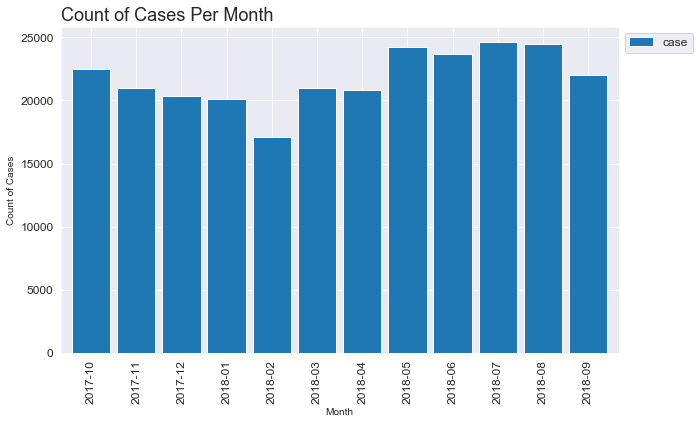

In [18]:
df.groupby('year_month').count().plot(y = 'case', 
                                      kind='bar',
                                      figsize=(10,6),
                                      width=0.85,
                                      fontsize=12,
                                      colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                               prop={'size': 12})

plt.xlabel('Month')
plt.ylabel('Count of Cases')
plt.title('Count of Cases Per Month', loc='left', fontsize=18)

Unsuprisingly there little obvious variation in the number of crimes committed per month other than an apparent drop-off in February. 

### Number of crimes occuring on each day

Text(0,1,'Count of Cases Per Day of Week [1 is a Tuesday]')

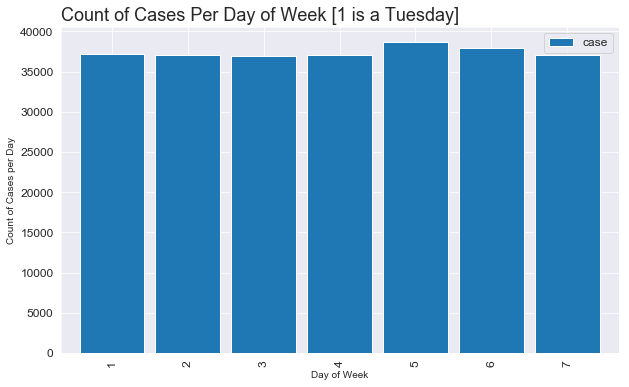

In [19]:
df.groupby('day').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Day of Week')
plt.ylabel('Count of Cases per Day')
plt.title('Count of Cases Per Day of Week [1 is a Tuesday]', loc='left', fontsize=18)

There is a small increase in crime reported at the weekend, Saturday and Sunday, but nothing that couldbe considered significant.

### Number of crimes occuring in each hour

Text(0,1,'Count of Cases Per Hour]')

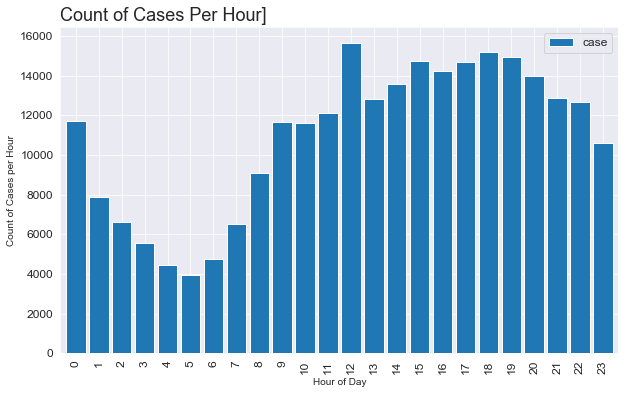

In [20]:
df.groupby('hour').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Hour of Day')
plt.ylabel('Count of Cases per Hour')
plt.title('Count of Cases Per Hour]', loc='left', fontsize=18)

There is an expected fall-off in reported crime rates after midnight before elevating again after eight in the morning.

Now let's look at the Crime Categories.

In [21]:
# Number of unique Crime categories bases on the Primary Description
df.primary_description.nunique()

32

In [22]:
# What Crimes are the 3 most commonly occuring ones 
df[['primary_description', 'case']].groupby(
    ['primary_description'], as_index=False).count().sort_values(
    'case', ascending=False).head(3)

,primary_description,case
30,THEFT,63629
2,BATTERY,49498
6,CRIMINAL DAMAGE,27980


In [23]:
# Create a list of the 10 most commonly occuring crimes
top_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:10].axes[0].tolist()

# Create a list of the 3 most commonly occuring crimes
top_three_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:3].axes[0].tolist()

# Create a list of the 2 most commonly occuring crimes
top_two_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:2].axes[0].tolist()

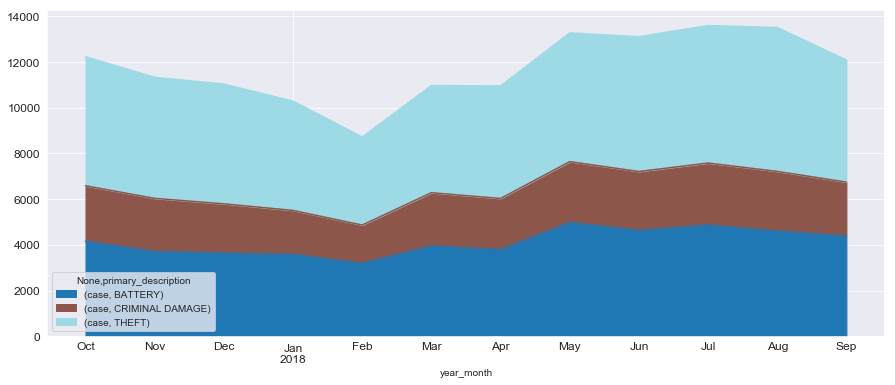

In [30]:
# Create a new data frame with just the top 10 crimes
df_top_crimes = df[df['primary_description'].isin(top_crimes)].copy()

# Create a new data frame with just the top 10 crimes
df_top3_crimes = df[df['primary_description'].isin(top_three_crimes)].copy()

df_top3_crimes[['case', 'primary_description', 'year_month']].pivot_table(
    index='year_month', 
    columns='primary_description', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20')

Text(0,1,'Count of Cases Per Hour]')

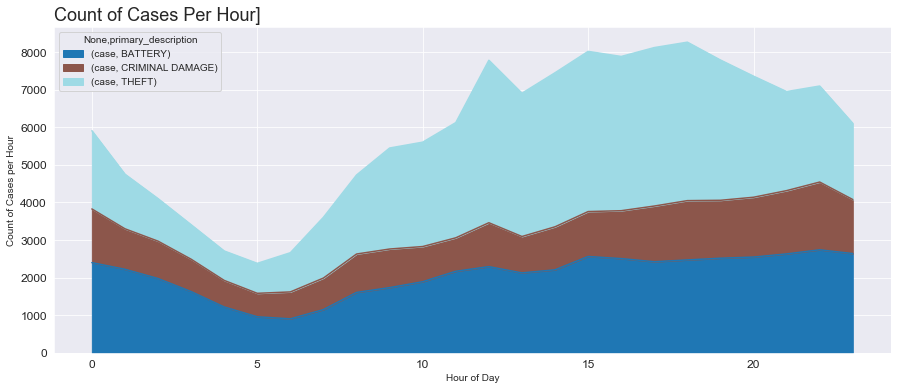

In [31]:
df_top3_crimes[['case', 'primary_description', 'hour']].pivot_table(
    index='hour', 
    columns='primary_description', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20')

plt.xlabel('Hour of Day')
plt.ylabel('Count of Cases per Hour')
plt.title('Count of Cases Per Hour]', loc='left', fontsize=18)

### Visual Crimes on map of Chicago

In [84]:
df_top_crimes.dtypes

case                           object
date_of_occurrence     datetime64[ns]
block                          object
primary_description            object
ward                          float64
latitude                      float64
longitude                     float64
hour                            int64
day_name                       object
day                             int64
month_name                     object
month                           int64
year                            int64
year_month                     object
zip                            object
street                         object
dtype: object

### Create a folium map with a different colour per crime

Colour each of the top 10 crimes with a different and plot on a Folium map.

In [32]:
# Create a list of colours. 
# We have  list of the top 10 crimes from earlier
colors = [
    'red',
    'blue',
    'gray',
    'orange',
    'beige',
    'green',
    'purple',
    'pink',
    'cadetblue',
    'black'
]

# Create a dictionary of colours to map to the crimes
dict_colours = dict(zip(top_crimes, colors))

# Add the colours colums to the df_top_crimes DataFrame
df_top_crimes['colour'] = df_top_crimes.primary_description.map(dict_colours)

The entire `df_top_crimes` DataFrame contains too many point to disply effeciently using Folium. To combat this we will just use the data from August 2018.

In [33]:
df_top_crimes_august = df_top_crimes[df_top_crimes.month_name == 'August']

# Pickle the DataFrame to Separate the Folium Maps into a Separate Notepad
df_top_crimes_august.to_pickle('crimes_august.pkl')

```python
# Define Chicago's geolocation coordinates
chicago_latitude = 41.85  
chicago_longitude = -87.75

# Define the world map centered around Chicago with a higher zoom level
chicago_map = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# display world map
chicago_map

# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, col in zip(df_top_crimes_august.latitude, 
                         df_top_crimes_august.longitude, 
                         df_top_crimes_august.colour):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1, # define how big you want the circle markers to be
            color=col,
            fill=True,
            fill_color=col,
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(incidents)```

![Markers image of Chicago](./capstone_images/markers.jpg)

```python
mc = MarkerCluster()

# Define the world map centered around Chicago with a higher zoom level
chicago_cluster = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# display world map
chicago_cluster

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in df_top_crimes_august.itertuples():
    mc.add_child(folium.Marker(
        location=[row.latitude,  row.longitude],
                 popup=row.primary_description))
 
chicago_cluster.add_child(mc)
chicago_cluster```

![Clusters image of Chicago](./capstone_images/clusters.jpg)

```python
from folium import plugins
from folium.plugins import HeatMap

chicago_heatmat = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11) 

# List comprehension to make out list of lists
heat_data = [[row['latitude'], 
              row['longitude']] for index, row in df_top_crimes_august.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(chicago_heatmat)

# Display the map
chicago_heatmat```

![Heatmap image of Chicago](./capstone_images/heatmap.jpg)

In [107]:
df_top_crimes.dtypes

case                           object
date_of_occurrence     datetime64[ns]
block                          object
primary_description            object
ward                          float64
latitude                      float64
longitude                     float64
hour                            int64
day_name                       object
day                             int64
month_name                     object
month                           int64
year                            int64
year_month                     object
zip                            object
street                         object
colour                         object
dtype: object

# Data Preparation for Modelling

Before we start modelling we need to prepare the data frame to include only mumerical data and by removing unneeded columns.

Rather than removing colums from `df_top_crimes` a new `df_features` DataFrame will be created with just the required columns. This `df_features` DataFrame will then be processed to remove Categorical Data Types and replace them with One Hot encoding. Finally the Dependant Variables will be Normalised and Principal Component Analysis will be used to reduce the dimensionality of the DataFrame.

In [34]:
# Start by copying the Latitude and Longitude to the new DataFrame
df_features = df_top_crimes[['latitude', 'longitude']]

# Next and One Hot Encoding of the hour, day and month variables
df_features = df_features.join(pd.get_dummies(df_top_crimes.hour, prefix='hour'))
df_features = df_features.join(pd.get_dummies(df_top_crimes.day_name))
df_features = df_features.join(pd.get_dummies(df_top_crimes.month_name))

# Finally add the ward & crimes column, copied from the original Primary Description column
df_features['ward'] = df_top_crimes[['ward']]
df_features['crimes'] = df_top_crimes[['primary_description']]

In [35]:
df_features.head()

,latitude,longitude,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September,ward,crimes
0,41.897895,-87.760744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,37.0,NARCOTICS
1,41.798635,-87.604823,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5.0,CRIMINAL DAMAGE
2,41.780946,-87.621995,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20.0,THEFT
3,41.965404,-87.736202,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.0,THEFT
5,41.891603,-87.745687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,28.0,MOTOR VEHICLE THEFT


There are a couple of further small changes to be made:
 - Create a smaller DataFrame of only the top three crimes
 - Create the X, dependant variables, DataFrames by dropping the Crimes column
 - Create the y, independant variable, 
 - Normailse the X Data

In [36]:
# Create a smaller DataFrame of only the top three crimes
df_features_3 = df_features[df_features['crimes'].isin(top_three_crimes)].copy()

# Create a smaller DataFrame of only the top two crimes
df_features_2 = df_features[df_features['crimes'].isin(top_two_crimes)].copy()

In [37]:
#  Create the X, dependant variables, DataFrames by dropping the Crimes column
X_10 = df_features.copy()
y_10 = X_10.crimes.values

X_10.drop('crimes', axis=1, inplace=True)
X_10 = preprocessing.StandardScaler().fit(X_10).transform(X_10)


X_3 = df_features_3.copy()
y_3 = X_3.crimes.values

X_3.drop('crimes', axis=1, inplace=True)
X_3 = preprocessing.StandardScaler().fit(X_3).transform(X_3)

X_2 = df_features_2.copy()
y_2 = X_2.crimes.values

X_2.drop('crimes', axis=1, inplace=True)
X_2 = preprocessing.StandardScaler().fit(X_2).transform(X_2)


In [114]:
# Set X = X_10
X = X_10
y = y_10

In [143]:
# Set X = X_3
X = X_3
y = y_3

In [38]:
# Set X = X_2
X = X_2
y = y_2

### K Nearest Neighbor(KNN)
Find the best k to build the model with the best accuracy.

Heighbours:  15   2018-09-27 18:30:05.079412
Heighbours:  15   2018-09-27 18:42:10.549026
Heighbours:  15   2018-09-27 18:54:24.891635
Heighbours:  15   2018-09-27 19:07:50.205988
Heighbours:  15   2018-09-27 19:20:38.551279
Heighbours:  15   2018-09-27 19:33:53.544815
Heighbours:  15   2018-09-27 19:50:07.531802


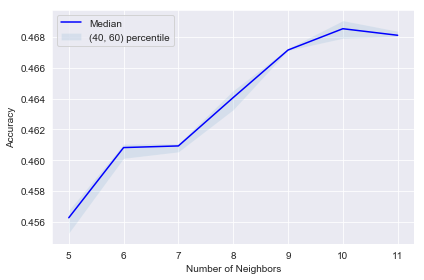

In [53]:
# Number of neighbours
neighs = range(5, 12)

# Store the scores
scores = np.zeros((len(neighs), 3))

for idx, neigh in enumerate(neighs):
    print('Heighbours: ', neigh, ' ', str(datetime.now()))
    model = KNeighborsClassifier(n_neighbors = neigh)
    scores[idx, : ] = cross_validate(model, n_splits = 5)

plt.plot(neighs, scores[ : , 1], 'b')
plt.fill_between(neighs, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

Depth:  10   2018-09-29 20:21:43.711835
Depth:  11   2018-09-29 20:21:52.729822
Depth:  12   2018-09-29 20:22:02.061035
Depth:  13   2018-09-29 20:22:11.946203
Depth:  14   2018-09-29 20:22:22.311324
Depth:  15   2018-09-29 20:22:33.211318


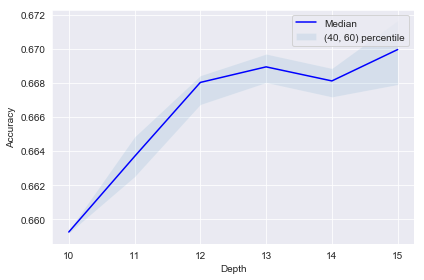

In [176]:
# Decision Tree
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier

depths = range(10, 16)
scores = np.zeros((len(depths), 3))
# scores = np.zeros((len(depths), 2))
for idx, depth in enumerate(depths):
    print('Depth: ', depth, ' ', str(datetime.now()))
    model = DecisionTreeClassifier(criterion = "entropy", max_depth = depth)
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(depths, scores[ : , 1], 'b')
plt.fill_between(depths, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()



C:  0.01   2018-09-29 19:55:35.850317
C:  0.03162277660168379   2018-09-29 19:55:54.529972
C:  0.1   2018-09-29 19:56:18.591961
C:  0.31622776601683794   2018-09-29 19:56:50.485827
C:  1.0   2018-09-29 19:57:08.953289
C:  3.1622776601683795   2018-09-29 19:57:32.267145


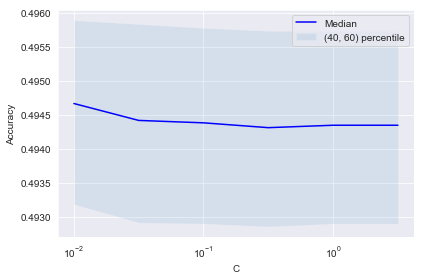

In [146]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

C = np.logspace(-2.0, 0.5, num = 6, endpoint = True)
scores = np.zeros((len(C), 3))
for idx, c in enumerate(C):
    print('C: ', c, ' ', str(datetime.now()))
    model = LogisticRegression(C = c, solver = 'liblinear')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(C, scores[ : , 1], 'b')
plt.xscale('log')
plt.fill_between(C, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

Alpha:  0.1   2018-09-29 19:58:32.874182
Alpha:  0.2   2018-09-29 19:58:38.732401
Alpha:  0.30000000000000004   2018-09-29 19:58:44.623051
Alpha:  0.4   2018-09-29 19:58:50.409530
Alpha:  0.5   2018-09-29 19:58:55.754630
Alpha:  0.6   2018-09-29 19:59:01.995696
Alpha:  0.7000000000000001   2018-09-29 19:59:07.390830
Alpha:  0.8   2018-09-29 19:59:12.751034
Alpha:  0.9   2018-09-29 19:59:18.619313
Alpha:  1.0   2018-09-29 19:59:24.275347


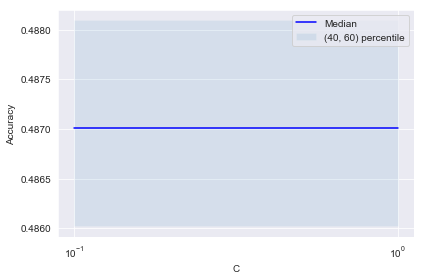

In [147]:
# Naive Bayes

alpha = np.linspace(0.1, 1, num=10)
scores = np.zeros((len(alpha), 3))
for idx, a in enumerate(alpha):
    print('Alpha: ', a, ' ', str(datetime.now()))
    model = BernoulliNB()
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(alpha, scores[ : , 1], 'b')
plt.xscale('log')
plt.fill_between(alpha, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

Estimator:  12   2018-09-29 19:59:54.411928
Estimator:  13   2018-09-29 20:00:28.651094
Estimator:  14   2018-09-29 20:01:07.014314
Estimator:  15   2018-09-29 20:01:46.615577
Estimator:  16   2018-09-29 20:02:28.741745
Estimator:  17   2018-09-29 20:03:12.244684


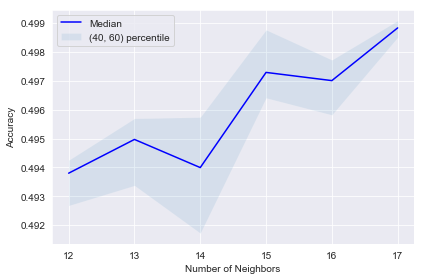

In [148]:
# Decision Forest using a Random Forest

est = range(12, 18)
scores = np.zeros((len(est), 3))
for idx, a in enumerate(est):
    print('Estimator: ', a, ' ', str(datetime.now()))
    model = RandomForestClassifier(n_estimators = a, max_features = 'sqrt')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(est, scores[ : , 1], 'b')
plt.fill_between(est, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [ ]:
def cross_validate_02(model, n_splits = 10):

    Ks = 10
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    ConfustionMx = [];
    for n in range(1,Ks):

        #Train Model and Predict
        k_fold = KFold(n_splits = n_splits)
        for train, test in k_fold.split(X):
            neigh = KNeighborsClassifier(n_neighbors = n).fit(X[train], y[train])
            yhat=neigh.predict(X[test])
            mean_acc[n-1] = metrics.accuracy_score(y[test], yhat)
            std_acc[n-1]=np.std(yhat==y[test])/np.sqrt(yhat.shape[0])

    mean_acc
    
def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores



# Import and Process FourSquare Data

In [39]:
import requests

page = requests.get("https://foursquare.com/explore?mode=url&near=Chicago%2C%20IL%2C%20United%20States&nearGeoId=72057594042815334&q=Top%20Picks")

from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
top_venues = soup.find_all('div', class_='venueDetails')

In [139]:
venue_columns = ['id', 
                 'score', 
                 'category', 
                 'name', 
                 'address',
                 'postalcode',
                 'city',
                 'href', 
                 'latitude', 
                 'longitude']

df_top_venues = pd.DataFrame(columns=venue_columns)

for venue in top_venues:
    venue_name = venue.find(target="_blank").get_text()
    venue_score = venue.find(class_="venueScore positive").get_text()
    venue_cat = venue.find(class_="categoryName").get_text()
    venue_href = venue.find(class_="venueName").h2.a['href']
    venue_id = venue_href.split('/')[-1]

    if 'promotedTipId' in venue_id: 
        continue
        
    # Get the properly formatted address and the latitude and longitude
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id, 
        cfg['client_id'],
        cfg['client_secret'],
        cfg['version'])
    
    result = requests.get(url).json()
    
    print(result)
    venue_address = result['response']['venue']['location']['address']
    venue_postalcode = result['response']['venue']['location']['postalCode']
    venue_city = result['response']['venue']['location']['city']
    venue_latitude = result['response']['venue']['location']['lat']
    venue_longitude = result['response']['venue']['location']['lng']
    
    df_top_venues = df_top_venues.append({'id': venue_id,
                                          'score': venue_score,
                                          'category': venue_cat,
                                          'name': venue_name,
                                          'address': venue_address,
                                          'postalcode': venue_postalcode,
                                          'city': venue_city,
                                          'href': venue_href,
                                          'latitude': venue_latitude,
                                          'longitude': venue_longitude}, ignore_index=True)


{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 592, 'type': 'others', 'items': [{'text': 'This 24.5-acre park features the work of world-renowned architects, planners, artists and designers.', 'likes': {'groups': [{'count': 111, 'type': 'others', 'items': []}], 'count': 111, 'summary': '111 likes'}, 'id': '4b6796c970c603bbf35291b4', 'lastUpvoteTimestamp': 1536762667, 'todo': {'count': 1}, 'logView': True, 'createdAt': 1265080009, 'disagreeCount': 0, 'url': 'http://millenniumpark.org/', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4b6796c970c603bbf35291b4', 'lang': 'en', 'lastVoteText': 'Upvoted 2 weeks ago', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/JEBEI3ZWJ53R2G2W.jpg'}, 'gender': 'none', 'firstName': 'Explore Chicago', 'id': '238086', 'type': 'page'}, 'agreeCount': 111}, {'text': 'First planned in 1997 to create new parkland in Grant Park & transform unsightly railroad tracks & parking lots, the Park has evo

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 118, 'type': 'others', 'items': [{'text': 'Water clears your mind, body and soul', 'likes': {'groups': [{'count': 15, 'type': 'others', 'items': []}], 'count': 15, 'summary': '15 likes'}, 'agreeCount': 15, 'id': '4f6e1e7ce4b06892a02b44a4', 'todo': {'count': 2}, 'createdAt': 1332616828, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4f6e1e7ce4b06892a02b44a4', 'lang': 'en', 'user': {'lastName': 'Crawley', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/41RVDENSK1VUXI1M.jpg'}, 'firstName': 'Dorothy', 'id': '24565590'}, 'logView': True}, {'text': 'This paved, 18-mile path along scenic Lake Shore Drive is often packed with joggers, bike commuters and tourists alike.', 'likes': {'groups': [{'count': 9, 'type': 'others', 'items': [{'lastName': 'Kaya', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/43223275-HVFYMB

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 644, 'type': 'others', 'items': [{'text': 'The collection encompasses more than 5,000 years of human expression from around the world & more than 260,000 pieces. The Modern Wing was opened in 2009 & is the largest expansion in their history.', 'likes': {'groups': [{'count': 50, 'type': 'others', 'items': []}], 'count': 50, 'summary': '50 likes'}, 'agreeCount': 51, 'lastUpvoteTimestamp': 1531162834, 'id': '4bbcb01570c603bbb80a97b4', 'todo': {'count': 199}, 'createdAt': 1270657045, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4bbcb01570c603bbb80a97b4', 'lang': 'en', 'lastVoteText': 'Upvoted Jul 9', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/376887-4KMRMDF4C2IGL1QX.png'}, 'gender': 'none', 'firstName': 'HISTORY', 'id': '376887', 'type': 'chain'}, 'logView': True}, {'text': 'Spend a few hours wandering around originals by Monet and Van Gogh to apprec

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 124, 'type': 'others', 'items': [{'text': 'The arctic char tartine at Publican Quality Meats is one of the 100 best things we ate this year. http://tmout.us/rLOtk', 'likes': {'groups': [{'count': 3, 'type': 'others', 'items': [{'lastName': 'Johnson', 'gender': 'none', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/blank_boy.png', 'default': True}, 'firstName': 'Nedra', 'id': '76104736'}, {'lastName': 'MiqaaEL', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/56251635-NOKFOMSPJG4FIEJ3.jpg'}, 'firstName': 'Nanya', 'id': '56251635'}, {'lastName': 'Покорский', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/1RXRD0OFHTW4MRG0.jpg'}, 'firstName': 'Олег', 'id': '45996679'}]}], 'count': 3, 'summary': '3 likes'}, 'id': '52b4b776498e8b98977664a4', 'todo': {'count': 2}, 'createdAt': 1387575158, 'entities': [{'object': {'url': 'http://t

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 92, 'type': 'others', 'items': [{'text': 'In "The Dark Knight" (2008), Harvey Dent (Aaron Eckhart) and his girlfriend Rachel Dawes (Maggie Gyllenhaal) show up for a ballet performance in scenes shot in the Chicago Theatre.', 'likes': {'groups': [{'count': 21, 'type': 'others', 'items': []}], 'count': 21, 'summary': '21 likes'}, 'id': '4b6362d570c603bbde1791b4', 'todo': {'count': 72}, 'logView': True, 'createdAt': 1264804565, 'disagreeCount': 0, 'url': 'http://www.explorechicago.org/city/en/things_see_do/attractions/tourism/the_chicago_theatre.html', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4b6362d570c603bbde1791b4', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/JEBEI3ZWJ53R2G2W.jpg'}, 'gender': 'none', 'firstName': 'Explore Chicago', 'id': '238086', 'type': 'page'}, 'agreeCount': 21}, {'text': 'In "Save the Last Dance" (2001), Sara (Julia Stiles) audi

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 33, 'type': 'others', 'items': [{'text': 'Come an hour early to hear some background about the pieces. Schmooze with your fellow socialites. You know you want to...', 'likes': {'groups': [{'count': 7, 'type': 'others', 'items': [{'lastName': 'Pissarreck', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/blank_girl.png', 'default': True}, 'firstName': 'Peggy', 'id': '70213833'}, {'lastName': 'T', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/HGKKJKUFA3EN0X3H.jpg'}, 'firstName': 'Abby', 'id': '11163858'}, {'lastName': 'Tabin', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/5222_1237306204.jpg'}, 'firstName': 'Janet', 'id': '5222'}, {'lastName': 'Proulx', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/FSLNBMJGMJL2BILW.jpg'}, 'firstName': 'Michonne', 'id': '5939989

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 124, 'type': 'others', 'items': [{'text': 'Chicago: Any park that plays host to a Barack Obama victory speech and a Radiohead show in the same year deserves to be at the top of this list. -IFC Viewer', 'likes': {'groups': [{'count': 32, 'type': 'others', 'items': []}], 'count': 32, 'summary': '32 likes'}, 'agreeCount': 32, 'id': '4c33943d3ffc9521f3a090f5', 'todo': {'count': 239}, 'createdAt': 1278448701, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4c33943d3ffc9521f3a090f5', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/SINIVGETGJ3JBZVC.jpg'}, 'gender': 'none', 'firstName': 'IFC', 'id': '470491', 'type': 'page'}, 'logView': True}, {'photo': {'visibility': 'public', 'suffix': '/14923118_mCshnGk6hlG2UQaijQkEQGK44D9pT2LSRHXkpkmxYJA.jpg', 'id': '5182a099454a640f14bf1044', 'width': 2100, 'height': 802, 'prefix': 'https://igx.4sqi.net/img/ge

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 68, 'type': 'others', 'items': [{'text': 'Often referred to as “landscape art under glass,” the free admission conservatory occupies approximately 4.5 acres inside and out, where thousands of plant species are on display.', 'likes': {'groups': [{'count': 31, 'type': 'others', 'items': []}], 'count': 31, 'summary': '31 likes'}, 'id': '4e70d22c814dd2cb96252461', 'todo': {'count': 110}, 'logView': True, 'createdAt': 1316016684, 'disagreeCount': 0, 'url': 'http://bit.ly/bmLimA', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4e70d22c814dd2cb96252461', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/JEBEI3ZWJ53R2G2W.jpg'}, 'gender': 'none', 'firstName': 'Explore Chicago', 'id': '238086', 'type': 'page'}, 'agreeCount': 31}, {'text': 'As the city’s horticulture haven continues rebuilding due to hail damage sustained last June, the temperature hovers at a humid 75 de

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 117, 'type': 'others', 'items': [{'photo': {'visibility': 'public', 'suffix': '/14923118_aCe0MurL1KJ3lXKdd_jGyrJpahKMgOxFJFgRvpZvBlc.jpg', 'id': '5182822850190c4a1b123101', 'width': 959, 'height': 639, 'prefix': 'https://igx.4sqi.net/img/general/', 'createdAt': 1367507496, 'source': {'name': 'Foursquare Web', 'url': 'https://foursquare.com'}}, 'text': 'Urban Kayaks are open for the season! Located at 270 E. Riverwalk South. Mon - Fri 10 a.m. - 6 p.m. and Sat - Sun 9 a.m. - 5 p.m. (312) 965-0035 http://urbankayaks.com/', 'likes': {'groups': [{'count': 18, 'type': 'others', 'items': []}], 'count': 18, 'summary': '18 likes'}, 'id': '51828226498ee62ddc9c6b6f', 'photourl': 'https://igx.4sqi.net/img/general/original/14923118_aCe0MurL1KJ3lXKdd_jGyrJpahKMgOxFJFgRvpZvBlc.jpg', 'todo': {'count': 7}, 'createdAt': 1367507494, 'entities': [{'object': {'url': 'http://urbankayaks.com/'}, 'indices': [145, 168], 'type': 'url'}], 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 196, 'type': 'others', 'items': [{'text': 'The crab cakes might as well be your sins because they are to die for.', 'likes': {'groups': [{'count': 5, 'type': 'others', 'items': [{'lastName': 'R', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/PIVUU1BWGFVO55XD.jpg'}, 'firstName': 'Veronica', 'id': '15081457'}, {'lastName': 'Clayton', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/30690967-QCQJSAZ052N4MBCL.jpg'}, 'firstName': 'Nicci', 'id': '30690967'}, {'lastName': 'Corrigan', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/6876779-EWVD0QWYAOSKQJBU.jpg'}, 'firstName': 'Patrick', 'id': '6876779'}, {'lastName': 'S.', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/1621127-XPRS5BWVWVJ0GSAK.jpg'}, 'firstName': 'DAVID', 'id': '1621127'}]}], 'count': 5, 'summary': '5 likes

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 43, 'type': 'others', 'items': [{'text': 'Their atomic cake is the,best.. Bananas,strawberrys,whip cream an chocolate an vanilla cake..', 'likes': {'groups': [{'count': 3, 'type': 'others', 'items': [{'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/58684932_yrqViZZw_gcuL2Ajj6aOP-zCPVbi7J1HmlAZfeaEhN_4_altjSBSx0k5NF1zDQVUAGsD2Spc_.jpg'}, 'gender': 'female', 'firstName': 'Dianne 💞', 'id': '58684932'}, {'lastName': 'Jansen', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/DQYAPPCZWQCDBVJL.jpg'}, 'firstName': 'Arlene', 'id': '52386009'}, {'lastName': 'Steinmetz', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/4XOV4EMD55AIIKVE.jpg'}, 'firstName': 'Richelle', 'id': '1899730'}]}], 'count': 3, 'summary': '3 likes'}, 'agreeCount': 3, 'id': '4e71ed6bfa76b23d31a65c9c', 'todo': {'count': 0}, 'createdAt': 1316089195, 'disagreeCount'

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 37, 'type': 'others', 'items': [{'text': 'Candy is dandy, but liquor is quicker.', 'likes': {'groups': [{'count': 4, 'type': 'others', 'items': [{'lastName': 'Iosifidis', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/48374324-EH3DRPSDFYO1TBU2.jpg'}, 'firstName': 'Stelios', 'id': '48374324'}, {'lastName': 'Williams', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/26273166-ZV3DXLVLKQ2SBIJA.jpg'}, 'firstName': 'Tranette', 'id': '26273166'}, {'lastName': 'Lee', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/M3CP3UWKYUBPQNNM.jpg'}, 'firstName': 'Rod', 'id': '22911702'}, {'lastName': 'Marianos', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/4543997_L2R2LZma_7oh9-Cz-FRXCIl8bQhLv_Fw01wSPFAOkNXKzjSAyWlBLNYc4xhi2vKxteGE1-ghQ.jpg'}, 'firstName': 'Nick', 'id': '4543997'}]}], 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 21, 'type': 'others', 'items': [{'text': 'A Park worker told me the composite boards get very HOT ... especially on days with no cloud cover ... so avoid walking your dog here on very hot sunny days to protect his paws.', 'likes': {'groups': [{'count': 5, 'type': 'others', 'items': [{'lastName': 'Monge', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/58638618-YFWGIHVT1YEPOOSU.jpg'}, 'firstName': 'Melissa', 'id': '58638618'}, {'lastName': 'Hicks', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/XDEXFRWBMNUSPDMW.jpg'}, 'firstName': 'Benjamen', 'id': '11965585'}, {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/BTVBDOGRBCRCA4J4.jpg'}, 'gender': 'female', 'firstName': 'mau', 'id': '2071853'}, {'lastName': 'Garcia Cristan', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/19422808_w-YFfS7e_

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 81, 'type': 'others', 'items': [{'text': 'The Music Box plays a mix of independent and foreign films, as well as classic (black and white) movie matinees, and midnight screenings of cult classics.', 'likes': {'groups': [{'count': 25, 'type': 'others', 'items': []}], 'count': 25, 'summary': '25 likes'}, 'id': '4b676e4970c603bb285091b4', 'todo': {'count': 171}, 'logView': True, 'createdAt': 1265069641, 'disagreeCount': 0, 'url': 'http://www.explorechicago.org', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4b676e4970c603bb285091b4', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/JEBEI3ZWJ53R2G2W.jpg'}, 'gender': 'none', 'firstName': 'Explore Chicago', 'id': '238086', 'type': 'page'}, 'agreeCount': 25}, {'text': "For old-time charm and movies that aren't the usual blockbusters, no place beats the Music Box.", 'likes': {'groups': [{'count': 19, 'type': 'others'

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 64, 'type': 'others', 'items': [{'text': 'Best little Italian store with incredible Italian Subs!', 'likes': {'groups': [{'count': 5, 'type': 'others', 'items': [{'lastName': 'Pocket Ninja', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/QI1WQXN5E0K344ZB.jpg'}, 'firstName': 'Purple', 'id': '11742212'}, {'lastName': 'Mack', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/196476-HC0L20IGEZP2ZMMH.jpg'}, 'firstName': 'Jamie', 'id': '196476'}, {'lastName': 'O.', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/0N03FH3ZOCJLUSYV.jpg'}, 'firstName': 'Nick', 'id': '31466216'}]}], 'count': 5, 'summary': '5 likes'}, 'agreeCount': 5, 'id': '4bca0fad70c603bbc33698b4', 'todo': {'count': 1}, 'createdAt': 1271533485, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4bca0fad70c603bbc33698

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 58, 'type': 'others', 'items': [{'text': "Don't miss the chef demos! Every Wed. and Sat. at 10:30am...see some of the city's finest in action.", 'likes': {'groups': [{'count': 8, 'type': 'others', 'items': [{'lastName': 'Thomas', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/MGFGFVUN2O2RCDPR.jpg'}, 'firstName': 'Dana', 'id': '17936733'}, {'lastName': 'Brown', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/8089780-CEBVZHYPADS4ZRKL.jpg'}, 'firstName': 'Stephanie', 'id': '8089780'}, {'lastName': '2001', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/53979714-X3USVJYDOU42B55L'}, 'firstName': 'Gráfica', 'id': '53979714'}, {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/36766780-40ZTELSKQHAM53WU.jpg'}, 'gender': 'male', 'firstName': 'N@BYL', 'id': '36766780'}]}], 'count': 8, 'summary': 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 41, 'type': 'others', 'items': [{'text': 'Amazing park, lots of cool stuff and great trails', 'likes': {'groups': [{'count': 2, 'type': 'others', 'items': [{'lastName': 'Nebesar', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/RUL2I04VJBW2ZASS.jpg'}, 'firstName': 'Thomas', 'id': '41558828'}]}], 'count': 2, 'summary': '2 likes'}, 'agreeCount': 2, 'lastUpvoteTimestamp': 1532898724, 'id': '574afea1498e5e10fa3baddb', 'todo': {'count': 0}, 'createdAt': 1464532641, 'authorInteractionType': 'liked', 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/574afea1498e5e10fa3baddb', 'lang': 'en', 'lastVoteText': 'Upvoted Jul 29', 'user': {'lastName': 'Parker', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/350038-3NHTGQBRT20NZDBL.jpg'}, 'firstName': 'Dana', 'id': '350038'}, 'logView': True}, {'text': "Up for a little walk 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 102, 'type': 'others', 'items': [{'text': 'Check out the free Monday evening shows.', 'likes': {'groups': [{'count': 17, 'type': 'others', 'items': []}], 'count': 17, 'summary': '17 likes'}, 'agreeCount': 2, 'id': '4c0d3b2263c3ef3b39faa693', 'todo': {'count': 1}, 'createdAt': 1275935522, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4c0d3b2263c3ef3b39faa693', 'lang': 'en', 'user': {'lastName': 'D', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/0PSBSRVIQWGGTYQN.jpg'}, 'firstName': 'Ern', 'id': '138828'}, 'logView': True}, {'text': 'Listen and watch the Chicago Symphony OrchestraRiccardo Muti makes his debut as CSO music director with a free show in the park.', 'likes': {'groups': [{'count': 11, 'type': 'others', 'items': []}], 'count': 11, 'summary': '11 likes'}, 'id': '4c9cce610df79c74cd35131a', 'todo': {'count': 30}, 'logView': True, 'creat

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 65, 'type': 'others', 'items': [{'text': "Parents PLEASE CONTROL YOUR LITTLE BRATS! IF YOU DON'T I WILL!", 'likes': {'groups': [{'count': 12, 'type': 'others', 'items': []}], 'count': 12, 'summary': '12 likes'}, 'agreeCount': 12, 'id': '4faaeadbe4b02cf91fb56b56', 'todo': {'count': 0}, 'createdAt': 1336601307, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4faaeadbe4b02cf91fb56b56', 'lang': 'en', 'user': {'lastName': 'Marquez', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/EEIY3Y1O5VTLXBGD.jpg'}, 'firstName': 'Greg', 'id': '21359'}, 'logView': True}, {'text': 'Ken and Luke are great!', 'likes': {'groups': [{'count': 4, 'type': 'others', 'items': [{'lastName': 'Ocho', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/4RPGU2HWKWHHXP4N.jpg'}, 'firstName': 'M', 'id': '8333854'}, {'lastName': 'McCaskey', 'gender'

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 40, 'type': 'others', 'items': [{'text': 'An independent neighborhood bookstore, Unabridged Bookstore is known for its specialization in gay and lesbian titles, but carries something for the book lover in anyone', 'likes': {'groups': [{'count': 8, 'type': 'others', 'items': [{'lastName': 'Sing', 'gender': 'none', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/126173670-ZJ4AJUFZDZC0FH01.jpg'}, 'firstName': 'Jessica', 'id': '126173670'}, {'lastName': 'L', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/FYW3KVG42LOYQP3V.jpg'}, 'firstName': 'Linnéa', 'id': '11309257'}, {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/HUQJMDBOLG24V0HF.jpg'}, 'gender': 'female', 'firstName': 'Justine', 'id': '33403266'}, {'lastName': 'O', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/APKJM3DHOAH4ULIS.jpg'}, 'firstName': 'S

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 104, 'type': 'others', 'items': [{'text': 'Thought you’d want to know: Brendan Sodikoff has been nominated for Restaurateur of the Year in Time Out Chicago’s 2011 Eat Out Awards. Vote now!', 'likes': {'groups': [{'count': 52, 'type': 'others', 'items': []}], 'count': 52, 'summary': '52 likes'}, 'id': '4d5aa1396b028eec11495f82', 'todo': {'count': 22}, 'logView': True, 'createdAt': 1297785145, 'disagreeCount': 0, 'url': 'http://207.97.233.162/things-to-do/promotions/211603/time-out-chicagos-2011-eat-out-awards', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4d5aa1396b028eec11495f82', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/R2RSEQ533D211UR0.jpg'}, 'gender': 'none', 'firstName': 'Time Out Chicago', 'id': '843848', 'type': 'page'}, 'agreeCount': 2}, {'text': 'Try the steak tartare from our 100 Best list: If you can find a better steak tartare anywhere in 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 65, 'type': 'others', 'items': [{'text': 'As far as we’re concerned, this is a sun-soaked café rather than just a bike shop. How else do you explain the thoughtfully sourced products—from Southport Grocery cupcakes to Mast Brothers chocolate?', 'likes': {'groups': [{'count': 6, 'type': 'others', 'items': [{'lastName': 'Highlander', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/94411-W4UC4LNC1GAVR4VU.jpg'}, 'firstName': 'Global', 'id': '94411'}, {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/BVIONTINZ1QPOUF2.jpg'}, 'gender': 'male', 'firstName': 'Qasim', 'id': '34471452'}, {'lastName': 'Van Dunk', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/-302OPZBJTP3W2JZV.jpg'}, 'firstName': 'Christopher', 'id': '100049'}, {'lastName': '❤❤❤', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/177661

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 76, 'type': 'others', 'items': [{'text': "Extra creamy and creatively flavored, Jeni's has a remarkably ability to make other ice cream seem one dimensional&mdash;like it's missing something.", 'likes': {'groups': [{'count': 19, 'type': 'others', 'items': []}], 'count': 19, 'summary': '19 likes'}, 'agreeCount': 19, 'id': '5240a02511d26f5f08b8ae16', 'todo': {'count': 7}, 'createdAt': 1379967013, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/5240a02511d26f5f08b8ae16', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/12703379-OJSNA253S0GCOKZZ.png'}, 'gender': 'none', 'firstName': 'Serious Eats', 'id': '12703379', 'type': 'page'}, 'logView': True}, {'text': 'The sweet corn and black raspberry ice cream at Jeni’s Splendid Ice Creams is one of the 100 best things we ate this year. http://tmout.us/rLOtk', 'likes': {'groups': [{'count': 7, 'type':

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 15, 'type': 'others', 'items': [{'text': "Our tour guide Patti rocked it! The beer was great, she even took us to a great bar after! Can't beat that", 'likes': {'groups': [{'count': 2, 'type': 'others', 'items': [{'lastName': 'VdE', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/CGZ31XOIZZ22WBGT.png'}, 'firstName': 'Nicolas', 'id': '18488814'}, {'lastName': 'Osterman', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/MC2N3OLO1WGVHGVK.jpg'}, 'firstName': 'Andrew', 'id': '1007572'}]}], 'count': 2, 'summary': '2 likes'}, 'agreeCount': 2, 'id': '5212100611d2635883b33a67', 'todo': {'count': 0}, 'createdAt': 1376915462, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/5212100611d2635883b33a67', 'lang': 'en', 'user': {'lastName': 'Gidney', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 23, 'type': 'others', 'items': [{'text': 'Among the Park’s cool features are a pagoda-shaped pavilion, where you can catch a water taxi to downtown Chicago, and a unique railroad drawbridge.', 'likes': {'groups': [{'count': 21, 'type': 'others', 'items': []}], 'count': 21, 'summary': '21 likes'}, 'id': '4e70d193814dd2cb96250ba0', 'todo': {'count': 82}, 'logView': True, 'createdAt': 1316016531, 'disagreeCount': 0, 'url': 'http://bit.ly/121NnH', 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4e70d193814dd2cb96250ba0', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/JEBEI3ZWJ53R2G2W.jpg'}, 'gender': 'none', 'firstName': 'Explore Chicago', 'id': '238086', 'type': 'page'}, 'agreeCount': 21}, {'text': 'This 12-acre park was named after civic leader Ping Tom, who wanted to bring an outdoor gathering space to the Chinatown community.', 'likes': {'groups': [{'count': 

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 31, 'type': 'others', 'items': [{'text': 'Negronis on tap!', 'likes': {'groups': [{'count': 5, 'type': 'others', 'items': [{'lastName': 'Beatty', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/89222746-GBFITCLLIX3O4J4O.jpg'}, 'firstName': 'Gavin', 'id': '89222746'}, {'lastName': 'Joseph', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/QQUX4UTSZFU2VJ4W.jpg'}, 'firstName': 'Aaron', 'id': '2697398'}, {'lastName': 'P', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/15177637-RL4BCL1UKDZ1U1FE.jpg'}, 'firstName': 'Kevin', 'id': '15177637'}, {'lastName': 'F', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/LVITBUITADZS2R4E.jpg'}, 'firstName': 'Adam', 'id': '4684735'}]}], 'count': 5, 'summary': '5 likes'}, 'agreeCount': 5, 'id': '5392630d498e29ee4ea600ac', 'todo': {'count': 0},

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 91, 'type': 'others', 'items': [{'photo': {'visibility': 'public', 'suffix': '/92078275_tGR0uaSOJNVzgYzCs9RTkHUYBtoh2E0oaO4tDbI5QcY.jpg', 'id': '54396c63498ec6b45bd054a1', 'width': 4320, 'height': 2432, 'prefix': 'https://igx.4sqi.net/img/general/', 'createdAt': 1413049443, 'source': {'name': 'Foursquare for Android', 'url': 'https://foursquare.com/download/#/android'}}, 'text': 'Enchilada with a Fried Egg was awesome, so was the Pozole.', 'likes': {'groups': [{'count': 3, 'type': 'others', 'items': [{'lastName': 'Burts', 'gender': 'female', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/110192223-UF5IWGBVTOAYAHZF.jpg'}, 'firstName': 'Torkwase', 'id': '110192223'}, {'lastName': 'Chmielewski', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/XONHT4Q2ONZQKR43.jpg'}, 'firstName': 'Brad', 'id': '33190'}]}], 'count': 3, 'summary': '3 likes'}, 'agreeCount': 3, 'phot

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 114, 'type': 'others', 'items': [{'photo': {'visibility': 'public', 'suffix': '/268135_YOCKkpURI4b2le61dt3sdVQiiZdascrU3PS6wKDp5l4.jpg', 'id': '5267d284498e995583cd0cca', 'width': 640, 'height': 434, 'prefix': 'https://igx.4sqi.net/img/general/', 'createdAt': 1382535812, 'source': {'name': 'Foursquare Web', 'url': 'https://foursquare.com'}}, 'text': 'The thick-sliced applewood-smoked bacon biscuit comes with collard greens and a side of house-made Fresno chili hot sauce that they’ve appropriately dubbed Pao Pao Sauce.', 'likes': {'groups': [{'count': 21, 'type': 'others', 'items': []}], 'count': 21, 'summary': '21 likes'}, 'id': '5267d28311d224a9d3151c14', 'photourl': 'https://igx.4sqi.net/img/general/original/268135_YOCKkpURI4b2le61dt3sdVQiiZdascrU3PS6wKDp5l4.jpg', 'todo': {'count': 11}, 'createdAt': 1382535811, 'logView': True, 'url': 'http://www.thrillist.com/eat/chicago/logan-square/bang-bang-pie-shop-bang-ba

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 10, 'type': 'others', 'items': [{'text': 'The lakefront trail heading south to Hyde Park is the best for running in the summer.', 'likes': {'groups': [{'count': 2, 'type': 'others', 'items': [{'lastName': 'Bendoraytes', 'gender': 'male', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/EDCF3ZNWMNZE5Z2I.jpg'}, 'firstName': 'Rodolfo', 'id': '3651054'}, {'lastName': 'Smith', 'gender': 'none', 'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/blank_boy.png', 'default': True}, 'firstName': 'Tiffany', 'id': '70414691'}]}], 'count': 2, 'summary': '2 likes'}, 'agreeCount': 2, 'id': '51cebd65498e9b30fa5c25fd', 'todo': {'count': 0}, 'createdAt': 1372503397, 'authorInteractionType': 'liked', 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/51cebd65498e9b30fa5c25fd', 'lang': 'en', 'user': {'lastName': 'Tague', 'gender': 'female', 'photo': {'prefix': 'https://ig

{'response': {'venue': {'tips': {'groups': [{'name': 'All tips', 'count': 39, 'type': 'others', 'items': [{'text': "Don’t bother looking for a mosh pit. You're here for the fresh air, not the band. #DontBlowIt", 'likes': {'groups': [{'count': 13, 'type': 'others', 'items': []}], 'count': 13, 'summary': '13 likes'}, 'agreeCount': 13, 'id': '4e13a72e15208bcf94e083a8', 'todo': {'count': 10}, 'createdAt': 1309910830, 'disagreeCount': 0, 'type': 'user', 'canonicalUrl': 'https://foursquare.com/item/4e13a72e15208bcf94e083a8', 'lang': 'en', 'user': {'photo': {'prefix': 'https://igx.4sqi.net/img/user/', 'suffix': '/OPQBZKHJWZCBYSZP.jpg'}, 'gender': 'none', 'firstName': '30 Minutes Or Less', 'id': '10378159', 'type': 'page'}, 'logView': True}, {'text': 'Throw a frisbee around. Maybe take a walk through the zoo, and spend a few introspective moments pondering what it means to be human.', 'likes': {'groups': [{'count': 12, 'type': 'others', 'items': []}], 'count': 12, 'summary': '12 likes'}, 'agre

In [41]:
# Import the preprocesses data from the Pickle file
df_top_venues = pd.read_pickle('./capstone_data/top_venues.pkl')

In [48]:
df_top_venues.shape

(30, 10)

In [49]:
df_top_venues.dtypes

id             object
score         float64
category       object
name           object
address        object
postalcode     object
city           object
href           object
latitude      float64
longitude     float64
dtype: object

In [46]:
df_top_venues['score'] = pd.to_numeric(df_top_venues['score'], errors='coerce').fillna(0)

In [51]:
df_top_venues.score.describe()

count    30.000000
mean      9.523333
std       0.072793
min       9.400000
25%       9.500000
50%       9.500000
75%       9.600000
max       9.700000
Name: score, dtype: float64

In [47]:
df_top_venues.head()

,id,score,category,name,address,postalcode,city,href,latitude,longitude
0,42b75880f964a52090251fe3,9.7,Park,Millennium Park,201 E Randolph St,60601,Chicago,/v/millennium-park/42b75880f964a52090251fe3,41.882662,-87.623239
1,4b9511c7f964a520f38d34e3,9.6,Trail,Chicago Lakefront Trail,Lake Michigan Lakefront,60611,Chicago,/v/chicago-lakefront-trail/4b9511c7f964a520f38...,41.967053,-87.646909
2,49e9ef74f964a52011661fe3,9.6,Art Museum,The Art Institute of Chicago,111 S Michigan Ave,60603,Chicago,/v/the-art-institute-of-chicago/49e9ef74f964a5...,41.879665,-87.623630
3,4f2a0d0ae4b0837d0c4c2bc3,9.6,Deli / Bodega,Publican Quality Meats,825 W Fulton Market,60607,Chicago,/v/publican-quality-meats/4f2a0d0ae4b0837d0c4c...,41.886642,-87.648718
4,4aa05f40f964a520643f20e3,9.6,Theater,The Chicago Theatre,175 N State St,60601,Chicago,/v/the-chicago-theatre/4aa05f40f964a520643f20e3,41.885578,-87.627286


In [52]:
df_top_venues.to_pickle('./capstone_data/top_venues.pkl')

In [53]:
# Create a map with the top 10 locations

In [156]:
restaurants_columns = ['id',
                       'score', 
                       'category', 
                       'categoryID', 
                       'name', 
                       'address',
                       'postalcode',
                       'city',
                       'latitude',
                       'longitude', 
                       'venue_name', 
                       'venue_latitude',
                       'venue_longitude']

df_restaurant = pd.DataFrame(columns=restaurants_columns)

# Create a list of all the top venue latitude and longitude
top_venue_lats = df_top_venues['latitude'].values
top_venue_lngs = df_top_venues['longitude'].values

# Create a list of all the top venue names
top_venue_names = df_top_venues['name'].values

for ven_name, ven_lat, ven_long in zip(top_venue_names, top_venue_lats, top_venue_lngs):
    # print(ven_id, ven_name)
    
    # Configure additional Search parameters
    categoryId = '4d4b7105d754a06374d81259'
    radius = 500
    limit = 15
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
        cfg['client_id'],
        cfg['client_secret'],
        ven_lat,
        ven_long,
        cfg['version'],
        categoryId,
        radius,
        limit)
    
    results = requests.get(url).json()
    
    # print(results['response'])
    
    # Want a good selection of Restaurents
    # If less than 10 ignore
    if len(results['response']['venues']) < 10:
        continue
        
    # Create a new dataframe with the list of restaurants
    # Get the values for each Restaurant from the JSON
    for restaurant in results['response']['venues']:
 
        # Sometimes there is no address. If so continue
        # if restaurant['location']['address']:
        #     continue
        
        try:
            # Get location details
            rest_id = restaurant['id']
            rest_category = restaurant['categories'][0]['pluralName']
            rest_categoryID = restaurant['categories'][0]['id']
            rest_name = restaurant['name']
            rest_address = restaurant['location']['address']
            rest_postalcode = restaurant['location']['postalCode']
            rest_city = restaurant['location']['city']
            rest_latitude = restaurant['location']['lat']
            rest_longitude = restaurant['location']['lng']
            
            # Get the restaurant score and href
            rest_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
                rest_id, 
                cfg['client_id'],
                cfg['client_secret'],
                cfg['version'])

            result = requests.get(rest_url).json()

            rest_score = result['response']['venue']['rating']
            
            df_restaurant = df_restaurant.append({'id': rest_id,
                                                  'score': rest_score,
                                                  'category': rest_category,
                                                  'categoryID': rest_categoryID,
                                                  'name': rest_name,
                                                  'address': rest_address,
                                                  'postalcode': rest_postalcode,
                                                  'city': rest_city,
                                                  'latitude': rest_latitude,
                                                  'longitude': rest_longitude,
                                                  'venue_name': ven_name,
                                                  'venue_latitude': ven_lat,
                                                  'venue_longitude': ven_long}, ignore_index=True)
            
        except:
            continue



55669b9b498ee34e5249ea61 Gastropubs 4bf58dd8d48988d155941735 Cindy's 12 S Michigan Ave 60603 Chicago 41.88169538551873 -87.62460021795313
556509d6498e726bdec19fe9 Burger Joints 4bf58dd8d48988d16c941735 Shake Shack 12 S Michigan Ave 60603 Chicago 41.881672517022395 -87.62445548060445
49e749fbf964a52086641fe3 Gastropubs 4bf58dd8d48988d155941735 The Gage 24 S Michigan Ave 60603 Chicago 41.88131924185583 -87.6246421465911
4e879cdc93adfd051d6d609e Breakfast Spots 4bf58dd8d48988d143941735 Wildberry Pancakes & Cafe 130 E Randolph St 60601 Chicago 41.88459910689705 -87.62320339679718
49d8159cf964a520a05d1fe3 Pubs 4bf58dd8d48988d11b941735 Miller's Pub 134 S Wabash Ave 60603 Chicago 41.87991050687501 -87.62597186754361
5a43fb90898bdc16c171d6cb Donut Shops 4bf58dd8d48988d148941735 Stan’s Donuts 181 N. Michigan Ave 60601 Chicago 41.88537128151265 -87.62451561671243
4e667204091afcffda218e18 Bakeries 4bf58dd8d48988d16a941735 Magnolia Bakery 108 N State St 60602 Chicago 41.88418724189101 -87.62807811

55669b9b498ee34e5249ea61 Gastropubs 4bf58dd8d48988d155941735 Cindy's 12 S Michigan Ave 60603 Chicago 41.88169538551873 -87.62460021795313
556509d6498e726bdec19fe9 Burger Joints 4bf58dd8d48988d16c941735 Shake Shack 12 S Michigan Ave 60603 Chicago 41.881672517022395 -87.62445548060445
49d8159cf964a520a05d1fe3 Pubs 4bf58dd8d48988d11b941735 Miller's Pub 134 S Wabash Ave 60603 Chicago 41.87991050687501 -87.62597186754361
4c2b8f18ae6820a188021843 Coffee Shops 4bf58dd8d48988d1e0931735 Starbucks 17 E Monroe St 60603 Chicago 41.880144 -87.626877
49e749fbf964a52086641fe3 Gastropubs 4bf58dd8d48988d155941735 The Gage 24 S Michigan Ave 60603 Chicago 41.88131924185583 -87.6246421465911
55669b9b498ee34e5249ea61 Gastropubs 4bf58dd8d48988d155941735 Cindy's 12 S Michigan Ave 60603 Chicago 41.88169538551873 -87.62460021795313
553977b7498eb9779dcb0592 Cafés 4bf58dd8d48988d16d941735 Goddess and The Baker 33 S Wabash Ave 60603 Chicago 41.8813047949221 -87.62611682811053
556509d6498e726bdec19fe9 Burger Joint

51f7183b8bbdc6a6ae21592e Tiki Bars 56aa371be4b08b9a8d57354d Three Dots and a Dash 435 N Clark St 60654 Chicago 41.89027 -87.63069
4abfeffaf964a5201d9320e3 Pizza Places 4bf58dd8d48988d1ca941735 Giordano's 730 N Rush St 60611 Chicago 41.8959932895807 -87.62569583952427
4ac91938f964a5209abe20e3 American Restaurants 4bf58dd8d48988d14e941735 Sweetwater Tavern & Grille 225 N Michigan Ave 60601 Chicago 41.886368318570725 -87.62428164482117
51b0b828498ecb8d51e396ea New American Restaurants 4bf58dd8d48988d157941735 Beatrix 519 N Clark St 60654 Chicago 41.89148026650749 -87.63087360767099
592f142acf72a063b395cb43 Cafés 4bf58dd8d48988d16d941735 Nutella Cafe 189 N Michigan Avenue 60601 Chicago 41.88559525878139 -87.62447569769371
4b9a32a0f964a5200aa435e3 Bakeries 4bf58dd8d48988d16a941735 Weber's Bakery 7055 W Archer Ave 60638 Chicago 41.791907872167535 -87.7985986999637
4cf44c1bcc61a35daacb249e Mexican Restaurants 4bf58dd8d48988d1c1941735 Pepe's Mexican Restaurant 7026 W Archer Ave 60638 Chicago 4

57e575a7498edc223c6efabd Mexican Restaurants 4bf58dd8d48988d1c1941735 Tuco & Blondie 3358 N Southport Ave 60657 Chicago 41.94337681171732 -87.66414631786574
50171dbee4b08f3c8587bf18 American Restaurants 4bf58dd8d48988d14e941735 Crosby's Kitchen 3455 N Southport Ave 60657 Chicago 41.945185032507084 -87.66382961198941
4a824676f964a5200ff91fe3 Sandwich Places 4bf58dd8d48988d1c5941735 Potbelly Sandwich Shop 3424 N Southport Ave 60657 Chicago 41.944116 -87.664121
5228f072bce6872aefde90d0 Ice Cream Shops 4bf58dd8d48988d1c9941735 Jeni's Splendid Ice Creams 3404 N Southport Ave 60657 Chicago 41.9436026060672 -87.66402619739496
5462804d498e4d476eaee3b5 Breweries 50327c8591d4c4b30a586d5d Corridor Brewery & Provisions 3446 N Southport Ave 60657 Chicago 41.94477632656988 -87.66409224125067
4a6e8003f964a520d5d41fe3 Sandwich Places 4bf58dd8d48988d1c5941735 Bari 1120 W Grand Ave 60642 Chicago 41.89117781715653 -87.6556284832498
4b294468f964a520039c24e3 Bakeries 4bf58dd8d48988d16a941735 D'Amato's Bake

4a189b92f964a520d0791fe3 Pizza Places 4bf58dd8d48988d1ca941735 Giordano's 130 E Randolph St 60601 Chicago 41.8851301 -87.6237612
5a43fb90898bdc16c171d6cb Donut Shops 4bf58dd8d48988d148941735 Stan’s Donuts 181 N. Michigan Ave 60601 Chicago 41.88537128151265 -87.62451561671243
4e667204091afcffda218e18 Bakeries 4bf58dd8d48988d16a941735 Magnolia Bakery 108 N State St 60602 Chicago 41.88418724189101 -87.62807811436072
4b40d131f964a52088bb25e3 Coffee Shops 4bf58dd8d48988d1e0931735 Starbucks 200 N Michigan Ave 60601 Chicago 41.88594506102927 -87.62480898377109
592f142acf72a063b395cb43 Cafés 4bf58dd8d48988d16d941735 Nutella Cafe 189 N Michigan Avenue 60601 Chicago 41.88559525878139 -87.62447569769371
4ac91938f964a5209abe20e3 American Restaurants 4bf58dd8d48988d14e941735 Sweetwater Tavern & Grille 225 N Michigan Ave 60601 Chicago 41.886368318570725 -87.62428164482117
4a5bc165f964a520b9bb1fe3 Coffee Shops 4bf58dd8d48988d1e0931735 Intelligentsia Coffee 53 E Randolph St 60601 Chicago 41.8844890508

4aabf7edf964a520435b20e3 Bars 4bf58dd8d48988d116941735 The Diag 2856 N Southport Ave 60657 Chicago 41.93419992364342 -87.6637555350609
57214b89498ea56bba20b689 Vegetarian / Vegan Restaurants 4bf58dd8d48988d1d3941735 Left Coast Food & Juice 2878 N Lincoln Ave 60657 Chicago 41.93413851887932 -87.66091931697231
57d16eb2498e847d651db302 Restaurants 4bf58dd8d48988d1c4941735 Entente 3056 N Lincoln Ave 60657 Chicago 41.93725704111984 -87.6657064064598
4b15adaaf964a5205eb223e3 Fast Food Restaurants 4bf58dd8d48988d16e941735 McDonald's 2834 N Ashland Ave 60657 Chicago 41.933565 -87.66886
4b01bb10f964a520ed4422e3 Coffee Shops 4bf58dd8d48988d1e0931735 Starbucks 3045 Greenview 60657 Chicago 41.93771743 -87.66604791
4ae1a415f964a5208c8621e3 Donut Shops 4bf58dd8d48988d148941735 Dunkin Donuts 3000 N Ashland Ave 60657 Chicago 41.93622560315452 -87.66872207516063
5a8eea193731ee7c89433907 New American Restaurants 4bf58dd8d48988d157941735 Tied House 3157 N Southport Ave 60657 Chicago 41.939645911987554 -8

59f24e4135d3fc2f62bcecd0 New American Restaurants 4bf58dd8d48988d157941735 S.K.Y. 1239 W 18th St 60608 Chicago 41.85786076872874 -87.65781234154781
4ab56128f964a5204b7420e3 BBQ Joints 4bf58dd8d48988d1df931735 Honky Tonk BBQ 1800 S Racine Ave 60608 Chicago 41.85795887732719 -87.65650767468985
5aea5b4bcbcdee002cc81f56 Restaurants 4bf58dd8d48988d1c4941735 Monnie Burke’s 1163 W 18th St 60608 Chicago 41.85782398582006 -87.65563187490626
51faffb8498e2f68d5d3285f Mexican Restaurants 4bf58dd8d48988d1c1941735 La Vaca Margarita Bar 1160 W 18th St 60608 Chicago 41.858224876383915 -87.65570047918192
4be51474910020a15fa2d214 Mexican Restaurants 4bf58dd8d48988d1c1941735 Coyotes Restaurant 1451 W 18th St 60608 Chicago 41.857828731728446 -87.66350505873794
4be4fec05254d13a067d60e1 Fast Food Restaurants 4bf58dd8d48988d16e941735 McDonald's 1664 S Blue Island Ave 60608 Chicago 41.858465780756745 -87.6609293371439
528ba1d311d28bca4130266d Taco Places 4bf58dd8d48988d151941735 Atotonilcos 1637 S Blue Island

4c19629a4ff90f47c4e60f49 Performing Arts Venues 4bf58dd8d48988d1f2931735 Theater On The Lake 2401 N. Lake Shore Drive 60614 Chicago 41.927100329095175 -87.63073841677247
4a81b6c6f964a52055f71fe3 Sushi Restaurants 4bf58dd8d48988d1d2941735 Sushi Para II 2256 N Clark St 60614 Chicago 41.92356539361453 -87.63920154145613
5907649f12c8f05bcac2dda7 Peruvian Restaurants 4eb1bfa43b7b52c0e1adc2e8 Chopo Chicken 2460 N Clark St 60614 Chicago 41.927028575695374 -87.64143948666671
431e2d80f964a52082271fe3 Italian Restaurants 4bf58dd8d48988d110941735 The Pasta Bowl 2434 N Clark St 60614 Chicago 41.926458268236566 -87.64116666886112
4b1b2384f964a520bef823e3 New American Restaurants 4bf58dd8d48988d157941735 North Pond 2610 N Cannon Dr 60614 Chicago 41.92973243292843 -87.63759402061433
52c04c43498ecaf112b9c5c4 Bakeries 4bf58dd8d48988d16a941735 Vanille Patisserie 2108 N Clark St 60614 Chicago 41.92046453451077 -87.63740174058803
569b9192498e38b72f7e9f51 Donut Shops 4bf58dd8d48988d148941735 Firecakes 2453

In [54]:
df_restaurant = pd.read_pickle('./capstone_data/restaurants.pkl')

In [55]:
df_restaurant.shape

(387, 13)

In [158]:
# Find the best place to eat at each of the top 10 locations

In [159]:
df_restaurant.head()

,id,score,category,categoryID,name,address,postalcode,city,latitude,longitude,venue_name,venue_latitude,venue_longitude
0,55669b9b498ee34e5249ea61,9.2,Gastropubs,4bf58dd8d48988d155941735,Cindy's,12 S Michigan Ave,60603,Chicago,41.881695,-87.624600,Millennium Park,41.882662,-87.623239
1,556509d6498e726bdec19fe9,8.4,Burger Joints,4bf58dd8d48988d16c941735,Shake Shack,12 S Michigan Ave,60603,Chicago,41.881673,-87.624455,Millennium Park,41.882662,-87.623239
2,49e749fbf964a52086641fe3,9.1,Gastropubs,4bf58dd8d48988d155941735,The Gage,24 S Michigan Ave,60603,Chicago,41.881319,-87.624642,Millennium Park,41.882662,-87.623239
3,4e879cdc93adfd051d6d609e,9.2,Breakfast Spots,4bf58dd8d48988d143941735,Wildberry Pancakes & Cafe,130 E Randolph St,60601,Chicago,41.884599,-87.623203,Millennium Park,41.882662,-87.623239
4,49d8159cf964a520a05d1fe3,8.5,Pubs,4bf58dd8d48988d11b941735,Miller's Pub,134 S Wabash Ave,60603,Chicago,41.879911,-87.625972,Millennium Park,41.882662,-87.623239


In [56]:
df_restaurant.dtypes

id                  object
score              float64
category            object
categoryID          object
name                object
address             object
postalcode          object
city                object
latitude           float64
longitude          float64
venue_name          object
venue_latitude     float64
venue_longitude    float64
dtype: object

In [57]:
df_restaurant.score.describe()

count    387.000000
mean       8.286563
std        0.930138
min        5.300000
25%        7.800000
50%        8.500000
75%        9.000000
max        9.500000
Name: score, dtype: float64

In [58]:
df_restaurant.venue_name.nunique()

28

In [59]:
df_restaurant.category.nunique()

72

In [60]:
df_restaurant.name.nunique()

240

In [76]:
df_restaurant.groupby('category')['name'].count().sort_values(ascending=False)[:10]

category
Coffee Shops                52
Pizza Places                29
Cafés                       24
Bakeries                    15
Burger Joints               15
Gastropubs                  15
New American Restaurants    15
Mexican Restaurants         14
Breakfast Spots             13
Fast Food Restaurants       13
Name: name, dtype: int64

In [78]:
df_restaurant.groupby('category')['score'].mean().sort_values(ascending=False)[:10]

category
Pie Shops                           9.4000
French Restaurants                  9.4000
Molecular Gastronomy Restaurants    9.3000
Filipino Restaurants                9.2000
Cuban Restaurants                   9.1000
Ice Cream Shops                     9.0625
Mediterranean Restaurants           9.0600
Korean Restaurants                  9.0000
Latin American Restaurants          9.0000
Fish & Chips Shops                  9.0000
Name: score, dtype: float64

In [74]:
df_restaurant.to_pickle('./capstone_data/restaurants.pkl')

In [ ]:
# Create a map with the top 10 locations and the places to eat

In [ ]:
#For each of the locations add Crimes within 500 meters

In [ ]:
# Can we predict the crime